# 4 imputs (N,Z, uq,dq) and two outputs (Mass excess, seperation energey) in forked ANN

# Imports

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)
print(now)

C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-2-outputs-forked
2019-08-20-16-27-06


In [2]:
#%matplotlib notebook

# Read the data set

In [3]:
df = pd.read_csv("better-nuclei-19-08.csv")
print(df.info())
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
Z                                  3436 non-null int64
N                                  3436 non-null int64
UQ                                 3436 non-null int64
DQ                                 3436 non-null int64
Mass Excess [MeV]                  3436 non-null float64
Mass Error                         3436 non-null float64
Mass Estimated                     3436 non-null int64
Neutron separation energy [MeV]    3318 non-null float64
Separation Error                   3318 non-null float64
Separation Estimated               3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


Index(['Z', 'N', 'UQ', 'DQ', 'Mass Excess [MeV]', 'Mass Error',
       'Mass Estimated', 'Neutron separation energy [MeV]', 'Separation Error',
       'Separation Estimated'],
      dtype='object')

In [4]:
df = df.rename(columns=
               {"Mass Excess [MeV]": "d",
                "Z":'z',
                'N':'n',
                'UQ':"uq",
                'DQ':"dq",
                "Mass Error":"mass error",
                "Mass Estimated":"mass estimated",
                "Neutron separation energy [MeV]":"d2",
                "Separation Error":"separation error",
                "Separation Estimated":"separation estimated"               
               })
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
z                       3436 non-null int64
n                       3436 non-null int64
uq                      3436 non-null int64
dq                      3436 non-null int64
d                       3436 non-null float64
mass error              3436 non-null float64
mass estimated          3436 non-null int64
d2                      3318 non-null float64
separation error        3318 non-null float64
separation estimated    3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


In [5]:
df.describe()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
count,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3318.000000,3318.000000,3318.000000
mean,57.857392,82.034051,197.748836,221.925495,-24.144121,0.123589,0.272992,7.755557,0.164216,0.295660
std,27.809406,43.293558,98.188326,113.771063,56.200706,0.197548,0.445562,3.631747,0.254378,0.456408
min,0.000000,0.000000,1.000000,1.000000,-91.652853,0.000000,0.000000,-2.488000,0.000000,0.000000
25%,36.000000,47.000000,120.750000,131.000000,-65.400443,0.003006,0.000000,5.414787,0.005140,0.000000
50%,58.000000,81.000000,197.000000,219.000000,-39.335024,0.014474,0.000000,7.249960,0.025005,0.000000
75%,80.000000,114.000000,273.000000,308.000000,1.172301,0.196000,1.000000,9.654658,0.269058,1.000000
max,118.000000,177.000000,413.000000,472.000000,201.512000,2.003000,1.000000,27.715000,2.011000,1.000000


# Remove estimated Excess and estimated Seperation

In [6]:
not_estimated_filter = (df["mass estimated"] == 0)
df = df[not_estimated_filter]

not_estimated_filter = (df["separation estimated"] == 0)
df = df[not_estimated_filter]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


In [8]:
df.isnull().values.any()

False

In [9]:
df['z'].shape

(2337,)

In [10]:
df.count()

z                       2337
n                       2337
uq                      2337
dq                      2337
d                       2337
mass error              2337
mass estimated          2337
d2                      2337
separation error        2337
separation estimated    2337
dtype: int64

In [11]:
df.head()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
0,0,1,1,2,8.071317,4.000000e-07,0,0.00000,0.00000,0.0
2,1,1,3,3,13.135722,1.000000e-07,0,2.22457,0.00000,0.0
3,1,2,4,5,14.949810,2.000000e-07,0,6.25723,0.00000,0.0
4,1,3,5,7,24.621127,1.000000e-01,0,-1.60000,0.10000,0.0
5,1,4,6,9,32.892444,8.944300e-02,0,-0.20000,0.13416,0.0


# Plot seperation energy column

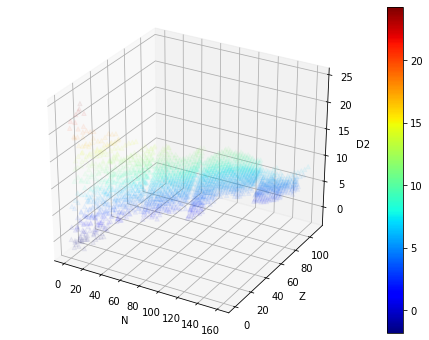

In [12]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d2']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D2')


plt.show()

In [13]:
df['d2'].to_numpy().shape

(2337,)

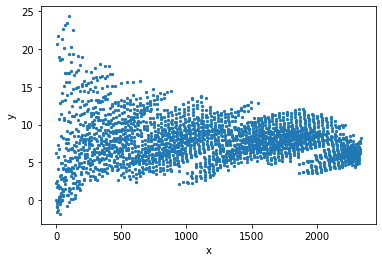

In [14]:
plt.scatter(range(df['d2'].count()), df['d2'].to_numpy(), s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Dividing Mass Excess by A = Z + N

In [15]:
zes = df['z'].to_numpy()
ns = df['n'].to_numpy()
a = zes + ns

des = df['d'].to_numpy() / a
df['d'] = des


# Plot Mass excess output column

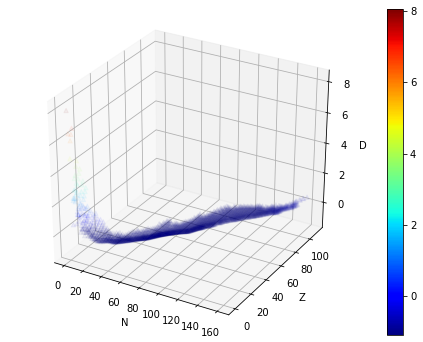

In [16]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Tripcolor

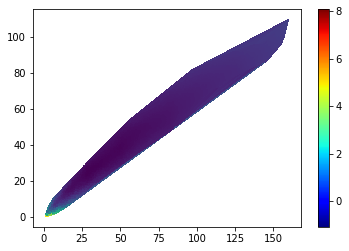

In [17]:
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

#yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)


fig, (ax)=plt.subplots(ncols=1)
ax.tripcolor(df["n"], df["z"], df["d"])
cb = fig.colorbar(colmap)

plt.show()

# Set X inputs

In [18]:
x = df[['z','n','dq','uq']]
print(x.info())
x = x.to_numpy()
print(x.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 4 columns):
z     2337 non-null int64
n     2337 non-null int64
dq    2337 non-null int64
uq    2337 non-null int64
dtypes: int64(4)
memory usage: 91.3 KB
None
(2337, 4)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


# Set Y inputs _(HERE CHANGE NUMBER OF INPUTS AND RESHAPE)

In [20]:
y = df[['d','d2']].to_numpy() #HERE
y.shape

(2337, 2)

In [21]:
y = y.reshape(-1,2) #HERE
y.shape

(2337, 2)

In [22]:
y[0:5]

array([[ 8.07131713,  0.        ],
       [ 6.56786088,  2.22457   ],
       [ 4.98326998,  6.25723   ],
       [ 6.15528175, -1.6       ],
       [ 6.5784888 , -0.2       ]])

# Prepare X_train_o, Y_train_o etc

In [23]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.2, random_state=1)
X_train_o, X_val_o, y_train_o, y_val_o  = train_test_split(X_train_o, y_train_o, test_size=0.2, random_state=1)
n_inputs = X_train_o.shape[1]
n_outputs = y_train_o.shape[1]
print(n_inputs)
print(n_outputs)
print(X_train_o.shape, X_test_o.shape,X_val_o.shape)

4
2
(1495, 4) (468, 4) (374, 4)


# Scaling

In [24]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_o.reshape(-1, n_inputs))
X_test = x_scaler.transform(X_test_o.reshape(-1, n_inputs))
X_val = x_scaler.transform(X_val_o.reshape(-1, n_inputs))

y_train = y_scaler.fit_transform(y_train_o.reshape(-1, n_outputs))
y_test = y_scaler.transform(y_test_o.reshape(-1, n_outputs))
y_val = y_scaler.transform(y_val_o.reshape(-1, n_outputs))

n_inputs = X_train.shape[1]
n_outputs = y_train.shape[1]
print(n_inputs)
print(n_outputs)

4
2


# ANN TOPOLOGY

In [25]:
def cust_layer(inputs,number_of_neurons, name, activation=None, dropout=False):
    init = tf.initializers.he_normal(seed=None)
    hidden = tf.keras.layers.Dense(number_of_neurons,
                                   name=name,
                                    kernel_initializer=init,
                                   activation = activation
                                )(inputs)    
    batch_norm = tf.keras.layers.BatchNormalization()(hidden, training=True)    
    if dropout:
        dropout_layer = tf.keras.layers.Dropout(0.5)(batch_norm)
        return dropout_layer
    else:
        return batch_norm
    
    
tf.reset_default_graph()
with tf.name_scope("dnn"):
    with tf.name_scope("inputs"):
        X_node = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y_node = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")
        
    n_shared_neurons = 150
    n_diff_neurons = 150
    n_shared_layers= 5
    n_layers = 5
    
    shared_layer = cust_layer(X_node,50,"hidden1")        
    
    for i in range(n_shared_layers):
        shared_layer = cust_layer(shared_layer,n_shared_neurons,f"hidden_shared_{i}",activation=tf.nn.elu,dropout=True)
    
    left_layers = cust_layer(shared_layer,n_diff_neurons,f"hidden_left_0",activation=tf.nn.elu,dropout=True)
    right_layers = cust_layer(shared_layer,n_diff_neurons,f"hidden_right_0",activation=tf.nn.elu,dropout=True)
    
    for j in range(n_layers):
        left_layers = cust_layer(left_layers,n_diff_neurons,f"hidden_left_{j+1}",activation=tf.nn.elu,dropout=True)
        right_layers = cust_layer(right_layers,n_diff_neurons,f"hidden_right_{j+1}",activation=tf.nn.elu,dropout=True)
    
    init = tf.initializers.he_normal()
    init2= tf.initializers.he_normal()
    y_pred_left = tf.keras.layers.Dense(1, name="output_left", kernel_initializer=init)(left_layers)
    y_pred_right = tf.keras.layers.Dense(1, name="output_right", kernel_initializer=init2)(right_layers)

    
with tf.name_scope('MSE_first_output'):
    
    error_f = tf.reshape(y_pred_left, [-1,]) - y_node[:,0]
    square_f = tf.square(error_f)
    mse_f = tf.reduce_mean(square_f, name="mse_first")
    variable_summaries(mse_f)
    print(y_node[:,0].get_shape())
    print(tf.reshape(y_pred_left, [-1,]).get_shape())

with tf.name_scope('MSE_second_output'):    
    error_s =tf.reshape(y_pred_right, [-1,])  - y_node[:,1]
    square_s = tf.square(error_s)
    mse_s = tf.reduce_mean(square_s, name="mse_second")
    variable_summaries(mse_s)

with tf.name_scope('MSE_combined'):    
    mse = mse_f + mse_s
    variable_summaries(mse)

with tf.name_scope('optimiser'):
    optimiser = tf.train.AdamOptimizer(0.001)
    training_op = optimiser.minimize(mse)

for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)

W0820 16:27:09.376651 20604 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-2-outputs-forked\utils.py:16: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0820 16:27:09.388620 20604 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-2-outputs-forked\utils.py:22: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



(?,)
(?,)


# File writers

In [26]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
test_writer = tf.summary.FileWriter(logdir + '/test')
valid_writer = tf.summary.FileWriter(logdir + '/valid')
init = tf.global_variables_initializer()

saver = tf.train.Saver()

checkpoint_path = os.path.join(dir_path, "sinus_tmp","sinus_full_model.ckpt")
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = os.path.join(dir_path, "model", "my_sinus_full_model")

# Number of epochs and batches

In [27]:
n_epochs = 2000
n_batches = 50

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = n_epochs * 0.2
print(max_epochs_without_progress)



400.0


# Training

In [28]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, n_batches):
            summary, _ = sess.run([merged, training_op],
                                  feed_dict={X_node: X_batch, y_node: y_batch})

        train_summary, _ = sess.run([merged, training_op],feed_dict={X_node: X_train, y_node: y_train})
        test_summary, _ =sess.run([merged, training_op],feed_dict={X_node: X_test, y_node: y_test})
        validation_summary, _ = sess.run([merged, training_op], feed_dict={X_node: X_val, y_node: y_val})

        train_writer.add_summary(train_summary, epoch)
        test_writer.add_summary(test_summary, epoch)
        valid_writer.add_summary(validation_summary,epoch)
        
        loss_train = mse.eval(feed_dict={X_node: X_train, y_node: y_train})
        loss_val = mse.eval(feed_dict={X_node: X_val, y_node: y_val})
        print(epoch, "train loss:", loss_train, "valid loss:", loss_val)

        iteration_skip = 10
        if epoch % iteration_skip == 0:
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

        if loss_val < best_loss:
            saver.save(sess, final_model_path)
            best_loss = loss_val
            print("best loss:", best_loss)
            epochs_without_progress = 0
        else:
            epochs_without_progress += 1
            if epochs_without_progress > max_epochs_without_progress:
                print("Early stopping")
                break


train_writer.close()
test_writer.close()
valid_writer.close()

0 train loss: 0.6027515 valid loss: 0.7361867
best loss: 0.7361867
1 train loss: 0.78859705 valid loss: 0.9510937
2 train loss: 0.6089316 valid loss: 0.7769449
3 train loss: 0.5074233 valid loss: 0.608367
best loss: 0.608367
4 train loss: 0.38992548 valid loss: 0.47752914
best loss: 0.47752914
5 train loss: 0.40960008 valid loss: 0.54432696
6 train loss: 0.46328145 valid loss: 0.5356622
7 train loss: 0.32468694 valid loss: 0.38547045
best loss: 0.38547045
8 train loss: 0.36028394 valid loss: 0.45163983
9 train loss: 0.29985797 valid loss: 0.39089143
10 train loss: 0.3179673 valid loss: 0.39079672
11 train loss: 0.471461 valid loss: 0.59113085
12 train loss: 0.37177622 valid loss: 0.4125458
13 train loss: 0.4142905 valid loss: 0.49674785
14 train loss: 0.41952798 valid loss: 0.48961478
15 train loss: 0.33867797 valid loss: 0.41928297
16 train loss: 0.30683443 valid loss: 0.37821501
best loss: 0.37821501
17 train loss: 0.3470627 valid loss: 0.4582884
18 train loss: 0.33212748 valid loss:

161 train loss: 0.2780444 valid loss: 0.24813396
162 train loss: 0.32893717 valid loss: 0.28489432
163 train loss: 0.25067595 valid loss: 0.27707303
164 train loss: 0.28213635 valid loss: 0.301996
165 train loss: 0.26879323 valid loss: 0.29918438
166 train loss: 0.2639143 valid loss: 0.2849509
167 train loss: 0.24777517 valid loss: 0.2501487
168 train loss: 0.36194298 valid loss: 0.3499533
169 train loss: 0.3172847 valid loss: 0.31479135
170 train loss: 0.24203235 valid loss: 0.27302635
171 train loss: 0.32468057 valid loss: 0.34154072
172 train loss: 0.2783306 valid loss: 0.31379634
173 train loss: 0.2691369 valid loss: 0.30679047
174 train loss: 0.22958146 valid loss: 0.24775174
175 train loss: 0.25053796 valid loss: 0.24841714
176 train loss: 0.45543638 valid loss: 0.50915647
177 train loss: 0.31924185 valid loss: 0.42072096
178 train loss: 0.24443087 valid loss: 0.2955458
179 train loss: 0.24554002 valid loss: 0.28012338
180 train loss: 0.2951988 valid loss: 0.3136247
181 train los

327 train loss: 0.26540512 valid loss: 0.33231816
328 train loss: 0.3056781 valid loss: 0.3202827
329 train loss: 0.22888477 valid loss: 0.24248487
330 train loss: 0.24375987 valid loss: 0.26129308
331 train loss: 0.21297026 valid loss: 0.22348516
best loss: 0.22348516
332 train loss: 0.23806821 valid loss: 0.24799515
333 train loss: 0.28744906 valid loss: 0.3169552
334 train loss: 0.2475107 valid loss: 0.28355724
335 train loss: 0.29112256 valid loss: 0.31384015
336 train loss: 0.23318395 valid loss: 0.2597996
337 train loss: 0.28562272 valid loss: 0.3145128
338 train loss: 0.2440157 valid loss: 0.25147155
339 train loss: 0.22967428 valid loss: 0.24889262
340 train loss: 0.23997755 valid loss: 0.27096605
341 train loss: 0.23749828 valid loss: 0.25686753
342 train loss: 0.22226796 valid loss: 0.2218276
best loss: 0.2218276
343 train loss: 0.32641754 valid loss: 0.3752945
344 train loss: 0.23081145 valid loss: 0.26396045
345 train loss: 0.21889752 valid loss: 0.23907867
346 train loss: 

491 train loss: 0.22809558 valid loss: 0.2582408
492 train loss: 0.2068249 valid loss: 0.22877204
493 train loss: 0.22013555 valid loss: 0.24897908
494 train loss: 0.25804847 valid loss: 0.28332677
495 train loss: 0.28292888 valid loss: 0.29739773
496 train loss: 0.29293197 valid loss: 0.26692858
497 train loss: 0.22714968 valid loss: 0.2519515
498 train loss: 0.2317549 valid loss: 0.23918104
499 train loss: 0.28156906 valid loss: 0.28941983
500 train loss: 0.2651153 valid loss: 0.30398354
501 train loss: 0.22013684 valid loss: 0.23346803
502 train loss: 0.22954477 valid loss: 0.25600544
503 train loss: 0.24248229 valid loss: 0.25178197
504 train loss: 0.2098071 valid loss: 0.24825996
505 train loss: 0.27174407 valid loss: 0.3303545
506 train loss: 0.22271268 valid loss: 0.23578101
507 train loss: 0.3265128 valid loss: 0.3161966
508 train loss: 0.27233985 valid loss: 0.26030892
509 train loss: 0.21651134 valid loss: 0.23116356
510 train loss: 0.31014612 valid loss: 0.33311275
511 train

655 train loss: 0.2234948 valid loss: 0.21944422
656 train loss: 0.22786212 valid loss: 0.24604739
657 train loss: 0.22561419 valid loss: 0.23989628
658 train loss: 0.2885684 valid loss: 0.23869509
659 train loss: 0.37691423 valid loss: 0.32707086
660 train loss: 0.28002104 valid loss: 0.31109208
661 train loss: 0.21370314 valid loss: 0.24797325
662 train loss: 0.21070981 valid loss: 0.2389176
663 train loss: 0.20626336 valid loss: 0.23259112
664 train loss: 0.218305 valid loss: 0.23706196
665 train loss: 0.23596953 valid loss: 0.26178074
666 train loss: 0.24352321 valid loss: 0.2491683
667 train loss: 0.22217843 valid loss: 0.22548439
668 train loss: 0.2213032 valid loss: 0.23785518
669 train loss: 0.23378134 valid loss: 0.2670223
670 train loss: 0.29472697 valid loss: 0.32347274
671 train loss: 0.25578743 valid loss: 0.2638697
672 train loss: 0.23385286 valid loss: 0.24577832
673 train loss: 0.23445903 valid loss: 0.26148298
674 train loss: 0.22205605 valid loss: 0.22481002
675 train

821 train loss: 0.22857755 valid loss: 0.26729563
822 train loss: 0.22388574 valid loss: 0.23938173
823 train loss: 0.23422329 valid loss: 0.27287492
824 train loss: 0.2353121 valid loss: 0.26561815
825 train loss: 0.23276842 valid loss: 0.28109106
826 train loss: 0.20636255 valid loss: 0.22100428
827 train loss: 0.23984575 valid loss: 0.26575407
828 train loss: 0.28320965 valid loss: 0.2546975
829 train loss: 0.23494385 valid loss: 0.24421766
830 train loss: 0.19722627 valid loss: 0.21444638
831 train loss: 0.21268503 valid loss: 0.22459614
832 train loss: 0.19957966 valid loss: 0.21232574
833 train loss: 0.26658338 valid loss: 0.2488781
834 train loss: 0.23380293 valid loss: 0.21182446
835 train loss: 0.22736269 valid loss: 0.2378858
836 train loss: 0.20524216 valid loss: 0.23721436
837 train loss: 0.22301042 valid loss: 0.22927086
838 train loss: 0.23662347 valid loss: 0.27416593
839 train loss: 0.2156271 valid loss: 0.21674533
840 train loss: 0.22553803 valid loss: 0.24768919
841 t

986 train loss: 0.19662726 valid loss: 0.2089957
987 train loss: 0.20908153 valid loss: 0.20756063
988 train loss: 0.20500687 valid loss: 0.21670395
989 train loss: 0.21303509 valid loss: 0.22250636
990 train loss: 0.23625433 valid loss: 0.3164187
991 train loss: 0.24743274 valid loss: 0.2595698
992 train loss: 0.2539399 valid loss: 0.28233728
993 train loss: 0.2049634 valid loss: 0.22772045
994 train loss: 0.2170273 valid loss: 0.21530464
995 train loss: 0.24794307 valid loss: 0.3016116
996 train loss: 0.2034587 valid loss: 0.21571417
997 train loss: 0.2440107 valid loss: 0.2718218
998 train loss: 0.25547552 valid loss: 0.25258517
999 train loss: 0.2495018 valid loss: 0.26624265
1000 train loss: 0.22581491 valid loss: 0.24712703
1001 train loss: 0.21121417 valid loss: 0.22206385
1002 train loss: 0.2525197 valid loss: 0.28343302
1003 train loss: 0.22952014 valid loss: 0.23958944
1004 train loss: 0.20830576 valid loss: 0.21628268
1005 train loss: 0.22932099 valid loss: 0.23666689
1006 t

1148 train loss: 0.283243 valid loss: 0.2481169
1149 train loss: 0.20744097 valid loss: 0.20504014
1150 train loss: 0.24011137 valid loss: 0.22960502
1151 train loss: 0.20867957 valid loss: 0.21795033
1152 train loss: 0.20439242 valid loss: 0.20643547
1153 train loss: 0.2203101 valid loss: 0.24222714
1154 train loss: 0.21368521 valid loss: 0.22579108
1155 train loss: 0.20028056 valid loss: 0.20680606
1156 train loss: 0.19667435 valid loss: 0.20776196
1157 train loss: 0.33993113 valid loss: 0.26549533
1158 train loss: 0.20950545 valid loss: 0.22297512
1159 train loss: 0.20279475 valid loss: 0.21996734
1160 train loss: 0.19470447 valid loss: 0.21612853
1161 train loss: 0.1961483 valid loss: 0.2104363
1162 train loss: 0.20235385 valid loss: 0.20942321
1163 train loss: 0.29522213 valid loss: 0.26690415
1164 train loss: 0.3698735 valid loss: 0.30173913
1165 train loss: 0.20021293 valid loss: 0.21672866
1166 train loss: 0.23187761 valid loss: 0.22454354
1167 train loss: 0.20185316 valid loss

1309 train loss: 0.22482148 valid loss: 0.23415177
1310 train loss: 0.20917831 valid loss: 0.21601969
1311 train loss: 0.19864452 valid loss: 0.19958012
1312 train loss: 0.20246431 valid loss: 0.21342039
1313 train loss: 0.19974905 valid loss: 0.19673173
1314 train loss: 0.20277569 valid loss: 0.21891187
1315 train loss: 0.2180706 valid loss: 0.21161948
1316 train loss: 0.20628831 valid loss: 0.2114078
1317 train loss: 0.21189857 valid loss: 0.22155958
1318 train loss: 0.20039766 valid loss: 0.2083529
1319 train loss: 0.20954926 valid loss: 0.20727968
1320 train loss: 0.22562993 valid loss: 0.20979683
1321 train loss: 0.20842665 valid loss: 0.23948854
1322 train loss: 0.27794915 valid loss: 0.24983917
1323 train loss: 0.20002063 valid loss: 0.20381494
1324 train loss: 0.19234088 valid loss: 0.20352468
1325 train loss: 0.2062335 valid loss: 0.21347255
1326 train loss: 0.25160393 valid loss: 0.22034094
1327 train loss: 0.20008792 valid loss: 0.20811523
1328 train loss: 0.20255327 valid l

1471 train loss: 0.22413701 valid loss: 0.21300551
1472 train loss: 0.19953282 valid loss: 0.20423833
1473 train loss: 0.21598291 valid loss: 0.23757075
1474 train loss: 0.22559714 valid loss: 0.24046475
1475 train loss: 0.21965694 valid loss: 0.22630675
1476 train loss: 0.21234377 valid loss: 0.21747681
1477 train loss: 0.22706437 valid loss: 0.26100957
1478 train loss: 0.19832398 valid loss: 0.20301591
1479 train loss: 0.20217244 valid loss: 0.19599763
1480 train loss: 0.21893597 valid loss: 0.23987973
1481 train loss: 0.21881084 valid loss: 0.2088917
1482 train loss: 0.27557874 valid loss: 0.2611613
1483 train loss: 0.19887541 valid loss: 0.19522917
1484 train loss: 0.21951143 valid loss: 0.23473704
1485 train loss: 0.20852058 valid loss: 0.20408088
1486 train loss: 0.20437688 valid loss: 0.19288278
best loss: 0.19288278
1487 train loss: 0.26421744 valid loss: 0.24282475
1488 train loss: 0.22309133 valid loss: 0.20790677
1489 train loss: 0.19419868 valid loss: 0.193347
1490 train lo

1632 train loss: 0.19358188 valid loss: 0.20078439
1633 train loss: 0.19403943 valid loss: 0.21174484
1634 train loss: 0.20142908 valid loss: 0.1934151
1635 train loss: 0.20233145 valid loss: 0.19292605
1636 train loss: 0.27073592 valid loss: 0.22149663
1637 train loss: 0.21292174 valid loss: 0.20020048
1638 train loss: 0.19598918 valid loss: 0.21482614
1639 train loss: 0.20437577 valid loss: 0.19926554
1640 train loss: 0.207774 valid loss: 0.20493194
1641 train loss: 0.22122897 valid loss: 0.19070229
1642 train loss: 0.23934203 valid loss: 0.22712398
1643 train loss: 0.20537922 valid loss: 0.22504437
1644 train loss: 0.24978344 valid loss: 0.22498992
1645 train loss: 0.25473052 valid loss: 0.25038946
1646 train loss: 0.19526605 valid loss: 0.19905344
1647 train loss: 0.20338231 valid loss: 0.20704834
1648 train loss: 0.22464529 valid loss: 0.2280035
1649 train loss: 0.21053536 valid loss: 0.21139832
1650 train loss: 0.19684657 valid loss: 0.20126708
1651 train loss: 0.25155407 valid l

1794 train loss: 0.19762164 valid loss: 0.20295005
1795 train loss: 0.20480499 valid loss: 0.20213829
1796 train loss: 0.23061045 valid loss: 0.23392944
1797 train loss: 0.19341357 valid loss: 0.18710844
1798 train loss: 0.2114447 valid loss: 0.20623949
1799 train loss: 0.20410538 valid loss: 0.19586694
1800 train loss: 0.19976585 valid loss: 0.19763379
1801 train loss: 0.19266598 valid loss: 0.2060611
1802 train loss: 0.21096198 valid loss: 0.21307051
1803 train loss: 0.34530228 valid loss: 0.287849
1804 train loss: 0.20256865 valid loss: 0.20028158
1805 train loss: 0.1915319 valid loss: 0.19627905
1806 train loss: 0.19691871 valid loss: 0.20053217
1807 train loss: 0.20054866 valid loss: 0.19391501
1808 train loss: 0.2073666 valid loss: 0.2289836
1809 train loss: 0.2115263 valid loss: 0.20431334
1810 train loss: 0.21260156 valid loss: 0.22580789
1811 train loss: 0.20234366 valid loss: 0.21843356
1812 train loss: 0.23661566 valid loss: 0.21491657
1813 train loss: 0.19163372 valid loss:

1956 train loss: 0.22066137 valid loss: 0.20596811
1957 train loss: 0.20188755 valid loss: 0.2089485
1958 train loss: 0.22859302 valid loss: 0.220539
1959 train loss: 0.20827892 valid loss: 0.20166945
1960 train loss: 0.19099699 valid loss: 0.19517039
1961 train loss: 0.19535612 valid loss: 0.19478741
1962 train loss: 0.2142245 valid loss: 0.23115835
1963 train loss: 0.20937474 valid loss: 0.20619857
1964 train loss: 0.20376158 valid loss: 0.21121956
1965 train loss: 0.23186131 valid loss: 0.21220468
1966 train loss: 0.21517307 valid loss: 0.20994033
1967 train loss: 0.21417122 valid loss: 0.20911586
1968 train loss: 0.20344651 valid loss: 0.19823532
1969 train loss: 0.19550931 valid loss: 0.1932146
1970 train loss: 0.20317069 valid loss: 0.20696317
1971 train loss: 0.21020836 valid loss: 0.2072709
1972 train loss: 0.19137403 valid loss: 0.19273508
1973 train loss: 0.21362971 valid loss: 0.21888706
1974 train loss: 0.20568234 valid loss: 0.2011745
1975 train loss: 0.20890805 valid loss

In [29]:
os.remove(checkpoint_epoch_path)

# Predictions

In [30]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    test_mse = mse.eval(feed_dict={X_node: X_test, y_node: y_test})
    print(test_mse)
    predictions_left = y_pred_left.eval(feed_dict={X_node: X_test, y_node: y_test})
    predictions_right = y_pred_right.eval(feed_dict={X_node: X_test, y_node: y_test})
    


W0820 16:55:49.444244 20604 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.23055942


In [31]:
print(predictions_left.shape)
print(predictions_right.shape)

(468, 1)
(468, 1)


# Concatenate predictions

In [32]:
predictions = np.concatenate((predictions_left, predictions_right), axis=1)
predictions.shape

(468, 2)

# Plot  _first (0th)_ output column of _predictions_

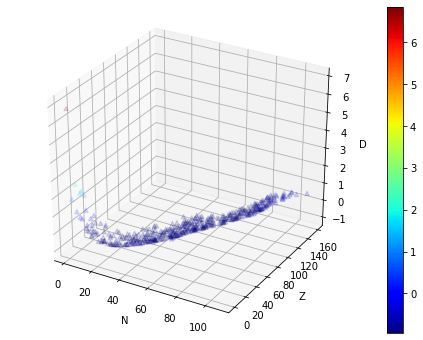

In [33]:
y_new_inverse = y_scaler.inverse_transform(predictions)
x_test_inverse = x_scaler.inverse_transform(X_test)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = y_new_inverse[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [34]:
y_test_o.shape[0]


468

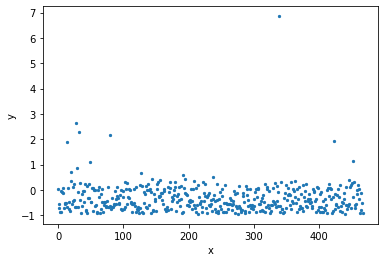

In [35]:
plt.scatter(range(y_new_inverse.shape[0]), y_new_inverse[:,0], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot _first 0th_ column of TEST set

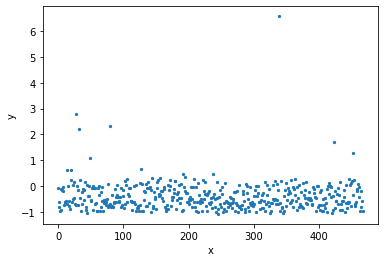

In [36]:
plt.scatter(range(y_test_o.shape[0]), y_test_o[:,0], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

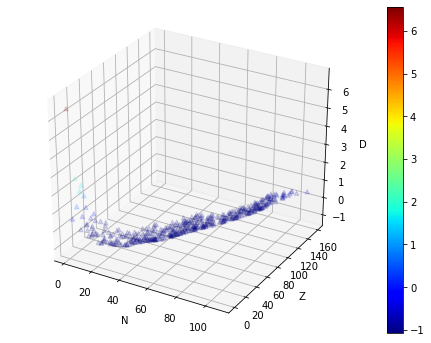

In [37]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = X_test_o[:,0]
ys = X_test_o[:,1]
zs = y_test_o[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Plot second column of Predictions 

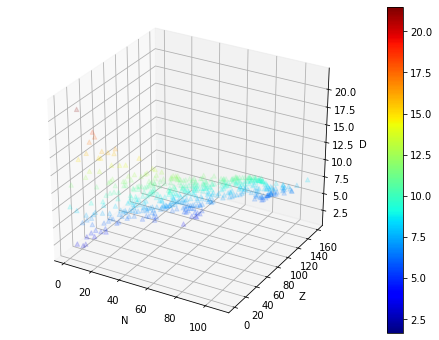

In [38]:
y_new_inverse = y_scaler.inverse_transform(predictions)
x_test_inverse = x_scaler.inverse_transform(X_test)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = y_new_inverse[:,1]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

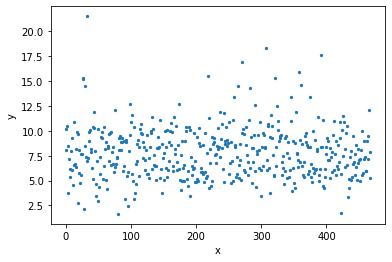

In [39]:
plt.scatter(range(y_new_inverse.shape[0]), y_new_inverse[:,1], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot second column of TEST set

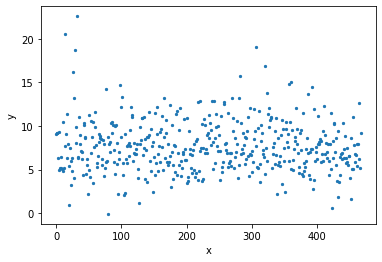

In [40]:
plt.scatter(range(y_test_o.shape[0]), y_test_o[:,1], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

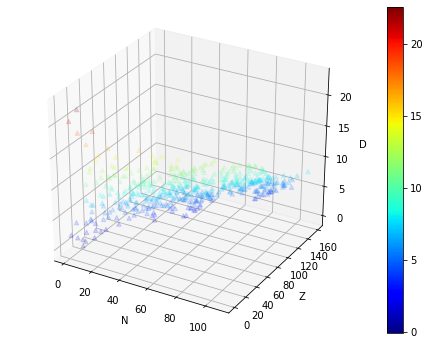

In [41]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = X_test_o[:,0]
ys = X_test_o[:,1]
zs = y_test_o[:,1]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Calculate _diff_ and _diff_abs_ (no distinction for columns)

In [42]:
#diff = np.square((y_new_inverse - y_test_o) / y_test_o)
substraction = y_new_inverse - y_test_o
diff = np.divide( substraction , y_test_o, out = substraction, where = y_test_o != 0)
diff_abs = y_new_inverse - y_test_o

In [43]:
diff_df = pd.DataFrame(data={'rel diff mass': diff[:,0],
                            'rel diff sep': diff[:,1],
                            'abs diff mass' : diff_abs[:,0],
                             'abs diff sep' : diff_abs[:,1],
                            })
diff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 4 columns):
rel diff mass    468 non-null float64
rel diff sep     468 non-null float64
abs diff mass    468 non-null float64
abs diff sep     468 non-null float64
dtypes: float64(4)
memory usage: 14.7 KB


# Replace inf and -inf with Nan, then drop the nans

In [44]:
diff_df = diff_df.replace([np.inf, -np.inf], np.nan)

In [45]:
print(diff_df.isnull().values.any())
print(diff_df.isnull().sum())
diff_df = diff_df.dropna()

False
rel diff mass    0
rel diff sep     0
abs diff mass    0
abs diff sep     0
dtype: int64


In [46]:
diff_df.describe()

,rel diff mass,rel diff sep,abs diff mass,abs diff sep
count,468.000000,468.000000,468.000000,468.000000
mean,-0.524912,0.027895,0.079073,0.130872
std,7.850729,1.028655,0.079080,1.394397
min,-132.513474,-20.989903,-0.139743,-9.692424
25%,-0.213731,-0.108659,0.060965,-0.934375
50%,-0.107905,0.048453,0.075906,0.341479
75%,-0.053064,0.166319,0.089570,1.114792
max,22.754351,3.289561,1.279219,5.555438


# Plot the relative diff of the first column

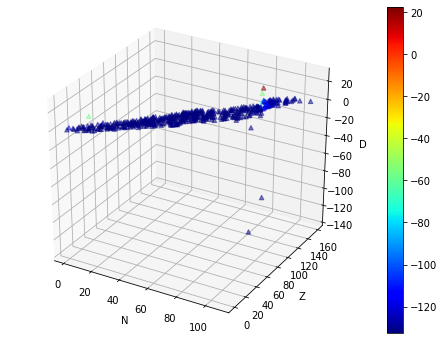

In [47]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = diff_df['rel diff mass']# diff[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.5)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [48]:
#%matplotlib notebook

In [49]:
vals = diff_df['rel diff mass'].to_numpy()
print(vals.shape)
print(vals.shape[0])

(468,)
468


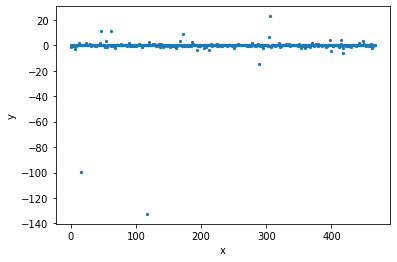

In [50]:
#plt.scatter(iterate_x, diff[:,0], s=5)

plt.scatter(range(vals.shape[0]),vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot the relative diff of the second column

In [51]:
vals = diff_df['rel diff sep'].to_numpy()
print(vals.shape)
print(vals.shape[0])

(468,)
468


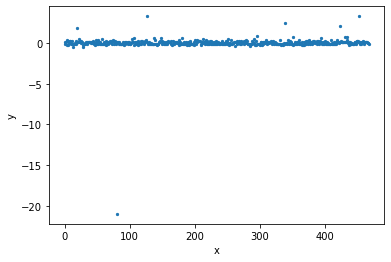

In [52]:
plt.scatter(range(vals.shape[0]), vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Diff ABSOLUTE of first column

In [53]:
vals = diff_df['abs diff mass'].to_numpy()
print(vals.shape)
range_x = range(vals.shape[0])

(468,)


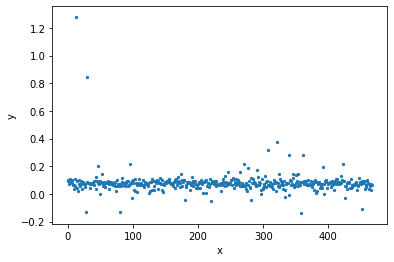

In [54]:
plt.scatter(range_x,vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Diff ABSOLUTE of second column

In [55]:
vals = diff_df['abs diff sep'].to_numpy()
print(vals.shape)
range_x = range(vals.shape[0])

(468,)


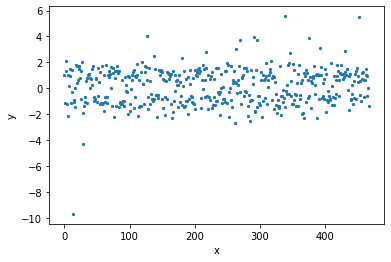

In [56]:
plt.scatter(range_x,vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()